# Gas Turbine CO Emission Predictor
We will apply ML models to predict CO emissions from a gas turbine located in Turkey. The [dataset](https://archive.ics.uci.edu/dataset/551/gas+turbine+co+and+nox+emission+data+set) used for this project was taken from the UCI machine learning repository (Heysem Kaya, 2022). It contains various measurements taken from different sensors located in a gas turbine in Turkey to study the emissions of carbon monoxide and nitrogen oxides.

## Loading the Data
The following table gives the description of each column along with their units.
| Name  | Description                    | Units                  |
|-------|--------------------------------|-----------------------|
| AT    | Ambient Temperature            | Celsius               |
| AP    | Ambient Pressure               | mbar                  |
| AH    | Ambient Humidity               | %                     |
| AFDP  | Air Filter Difference Pressure | mbar                  |
| GTEP  | Gas Turbine Exhaust Pressure   | mbar                  |
| TIT   | Turbine Inlet Temperature      | Celsius               |
| TAT   | Turbine After Temperature      | Celsius               |
| TEY   | Turbine Energy Yield           | Megawatt hour (MWH)   |
| CDP   | Compressor Discharge Pressure  | mbar                  |
| CO    | Carbon monoxide content        | mg/m3                 |
| NOX   | Nitrogen oxides content        | mg/mg3                |

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline     
sns.set(color_codes=True)

df = pd.read_csv('gt_2015.csv')
print('Shape of Dataframe:', df.shape)
df.head()

Shape of Dataframe: (7384, 11)


,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
0,1.95320,1020.1,84.985,2.5304,20.116,1048.7,544.92,116.27,10.799,7.4491,113.250
1,1.21910,1020.1,87.523,2.3937,18.584,1045.5,548.50,109.18,10.347,6.4684,112.020
2,0.94915,1022.2,78.335,2.7789,22.264,1068.8,549.95,125.88,11.256,3.6335,88.147
3,1.00750,1021.7,76.942,2.8170,23.358,1075.2,549.63,132.21,11.702,3.1972,87.078
4,1.28580,1021.6,76.732,2.8377,23.483,1076.2,549.68,133.58,11.737,2.3833,82.515


## Exploratory Data Analysis

In [2]:
df.dtypes

AT      float64
AP      float64
AH      float64
AFDP    float64
GTEP    float64
TIT     float64
TAT     float64
TEY     float64
CDP     float64
CO      float64
NOX     float64
dtype: object

In [3]:
df = df.drop(['NOX'], axis=1)
df.head()

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO
0,1.95320,1020.1,84.985,2.5304,20.116,1048.7,544.92,116.27,10.799,7.4491
1,1.21910,1020.1,87.523,2.3937,18.584,1045.5,548.50,109.18,10.347,6.4684
2,0.94915,1022.2,78.335,2.7789,22.264,1068.8,549.95,125.88,11.256,3.6335
3,1.00750,1021.7,76.942,2.8170,23.358,1075.2,549.63,132.21,11.702,3.1972
4,1.28580,1021.6,76.732,2.8377,23.483,1076.2,549.68,133.58,11.737,2.3833


In [4]:
print("Shape:", df.shape)
df.info()
df.describe().T

Shape: (7384, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7384 entries, 0 to 7383
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      7384 non-null   float64
 1   AP      7384 non-null   float64
 2   AH      7384 non-null   float64
 3   AFDP    7384 non-null   float64
 4   GTEP    7384 non-null   float64
 5   TIT     7384 non-null   float64
 6   TAT     7384 non-null   float64
 7   TEY     7384 non-null   float64
 8   CDP     7384 non-null   float64
 9   CO      7384 non-null   float64
dtypes: float64(10)
memory usage: 577.0 KB


,count,mean,std,min,25%,50%,75%,max
AT,7384.0,17.225259,8.095783,-6.2348,11.073250,17.4565,23.684750,37.1030
AP,7384.0,1014.509110,6.895430,989.4000,1009.675000,1014.0000,1018.300000,1036.6000
AH,7384.0,68.647464,13.541116,24.0850,59.447250,70.9520,79.653750,96.6660
AFDP,7384.0,3.598909,0.610226,2.3688,3.117300,3.5385,4.194825,5.2395
GTEP,7384.0,26.130149,4.473737,17.6980,23.147000,25.3310,30.018250,40.7160
TIT,7384.0,1078.974689,19.762449,1016.0000,1070.500000,1080.3000,1099.900000,1100.4000
TAT,7384.0,546.642484,5.489066,516.0400,544.747500,549.7200,550.030000,550.5900
TEY,7384.0,133.993380,16.179208,100.0200,126.255000,131.6000,147.160000,179.5000
CDP,7384.0,12.097025,1.136601,9.8708,11.465750,11.9330,13.148000,15.1590
CO,7384.0,3.129986,2.234962,0.2128,1.808175,2.5334,3.702550,41.0970


### Checking for missing values & duplicate rows

In [5]:
df.isnull().sum()

AT      0
AP      0
AH      0
AFDP    0
GTEP    0
TIT     0
TAT     0
TEY     0
CDP     0
CO      0
dtype: int64

In [31]:
df.duplicated().sum()

np.int64(0)

### Understanding distributions

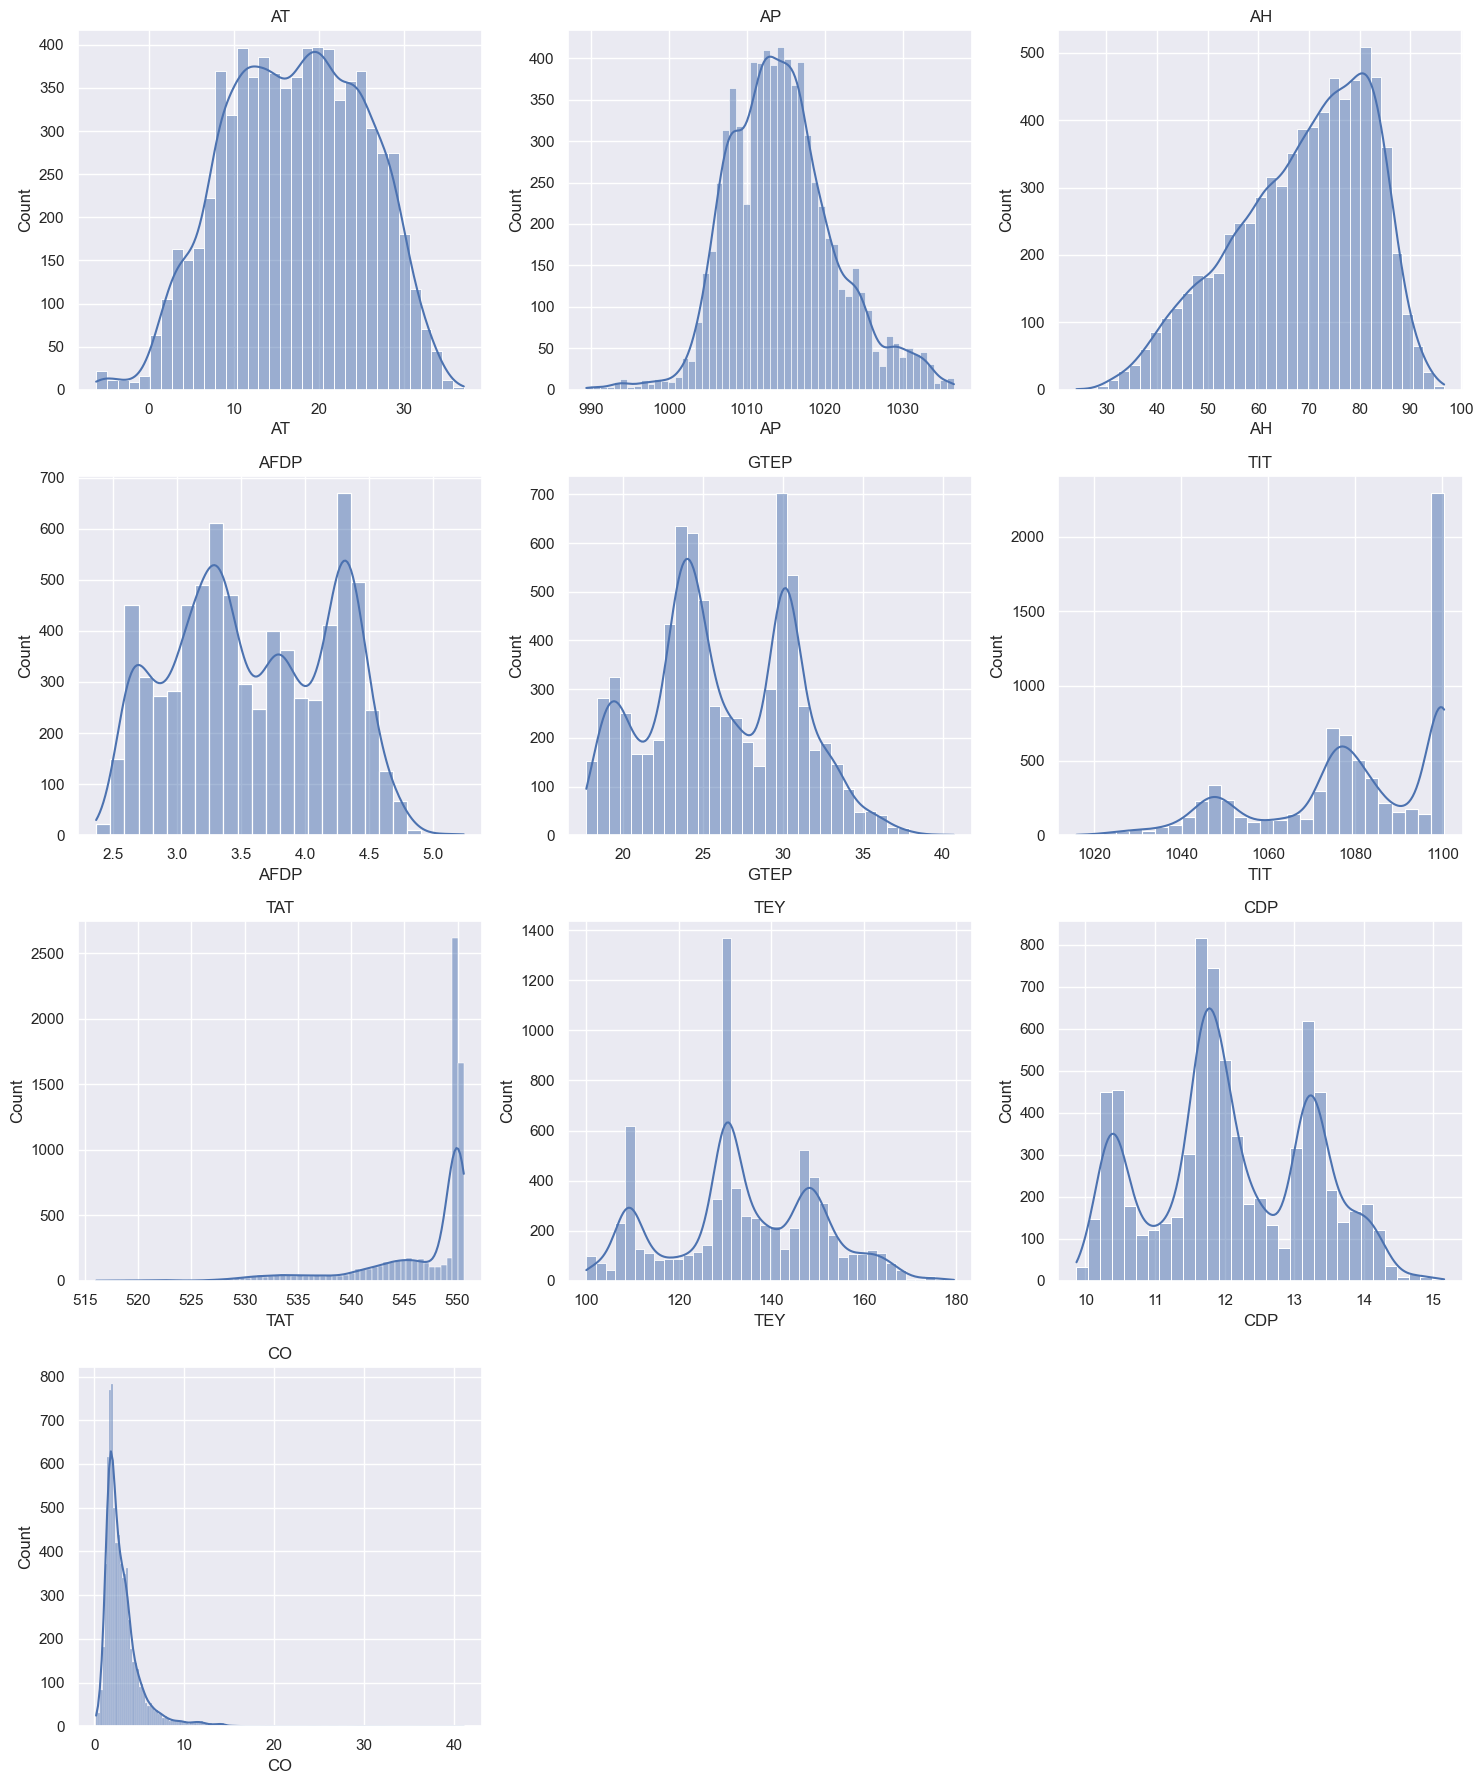

In [6]:
numeric_cols = df.select_dtypes(include=[np.number]).columns

plt.figure(figsize=(15, 18))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(4, 3, i)
    sns.histplot(df[col], kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

### Outlier Detection

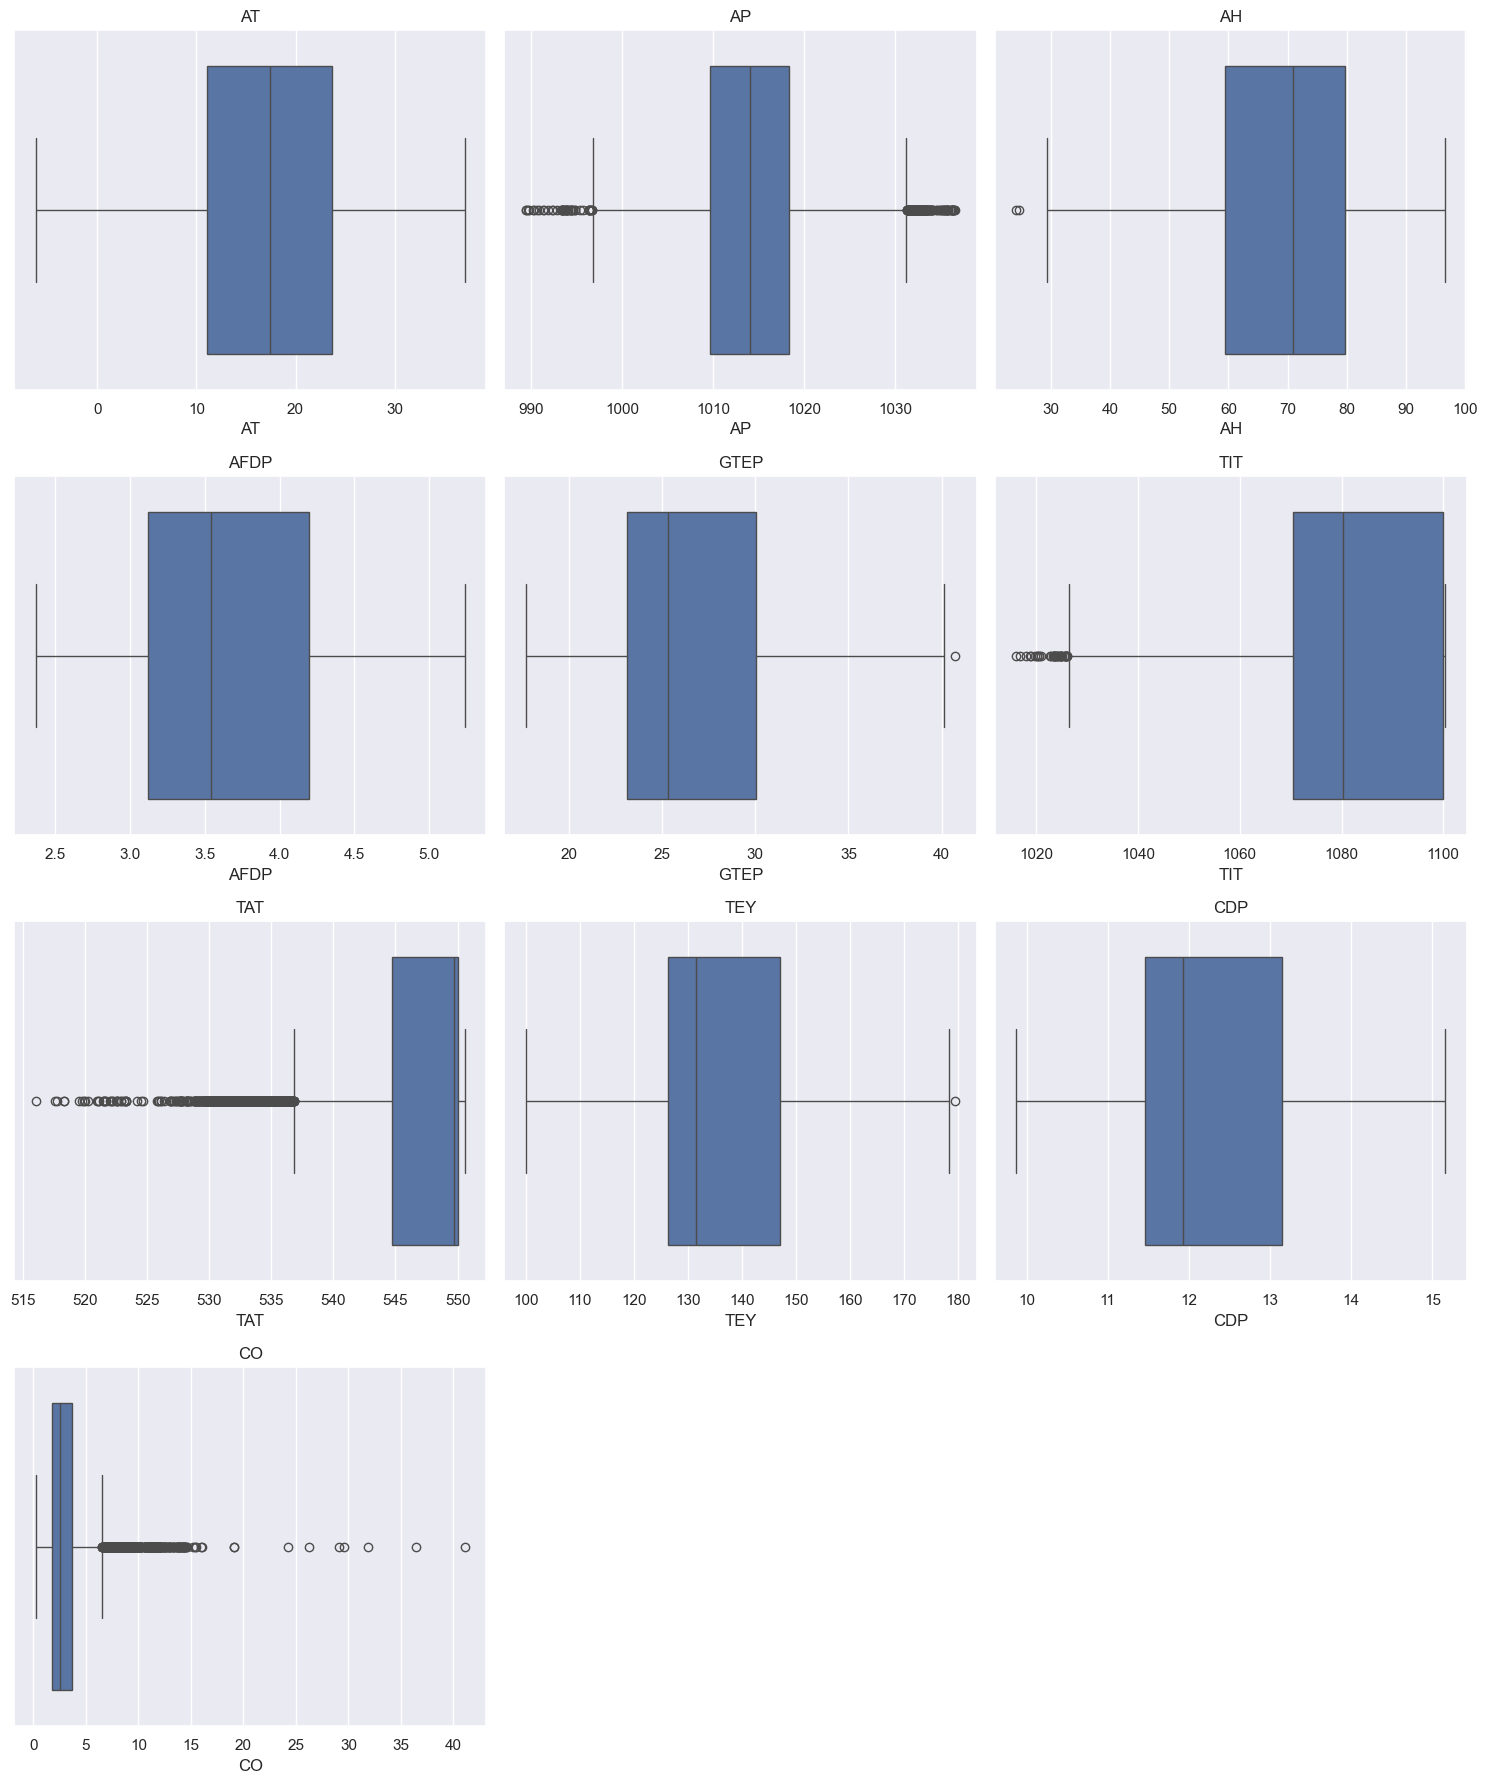

In [7]:
plt.figure(figsize=(15, 18))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(4, 3, i)
    sns.boxplot(x=df[col])
    plt.title(col)
plt.tight_layout()
plt.show()

### Correlation Heatmap

In [29]:
df.corr()

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO
AT,1.000000,-0.493098,-0.466288,0.468976,0.193578,0.330112,0.208277,0.109437,0.200909,-0.390647
AP,-0.493098,1.000000,0.084381,-0.094144,-0.043730,-0.081605,-0.290147,0.050326,0.029420,0.200945
AH,-0.466288,0.084381,1.000000,-0.245456,-0.297708,-0.260683,0.026251,-0.182732,-0.221706,0.158999
AFDP,0.468976,-0.094144,-0.245456,1.000000,0.843958,0.915128,-0.519807,0.884954,0.922991,-0.640789
GTEP,0.193578,-0.043730,-0.297708,0.843958,1.000000,0.892851,-0.620652,0.932337,0.938142,-0.557177
TIT,0.330112,-0.081605,-0.260683,0.915128,0.892851,1.000000,-0.396161,0.951813,0.951590,-0.738092
TAT,0.208277,-0.290147,0.026251,-0.519807,-0.620652,-0.396161,1.000000,-0.633933,-0.656613,0.025768
TEY,0.109437,0.050326,-0.182732,0.884954,0.932337,0.951813,-0.633933,1.000000,0.991207,-0.616791
CDP,0.200909,0.029420,-0.221706,0.922991,0.938142,0.951590,-0.656613,0.991207,1.000000,-0.612653
CO,-0.390647,0.200945,0.158999,-0.640789,-0.557177,-0.738092,0.025768,-0.616791,-0.612653,1.000000


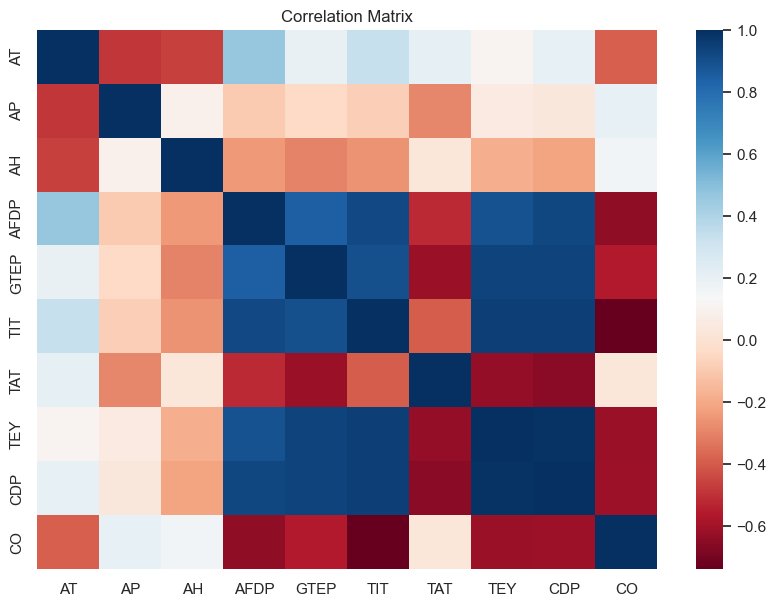

In [34]:
plt.figure(figsize=(10, 7))
sns.heatmap(df.corr(), cmap="RdBu", annot=False)
plt.title("Correlation Matrix")
plt.show()

### Scatter plot against CO

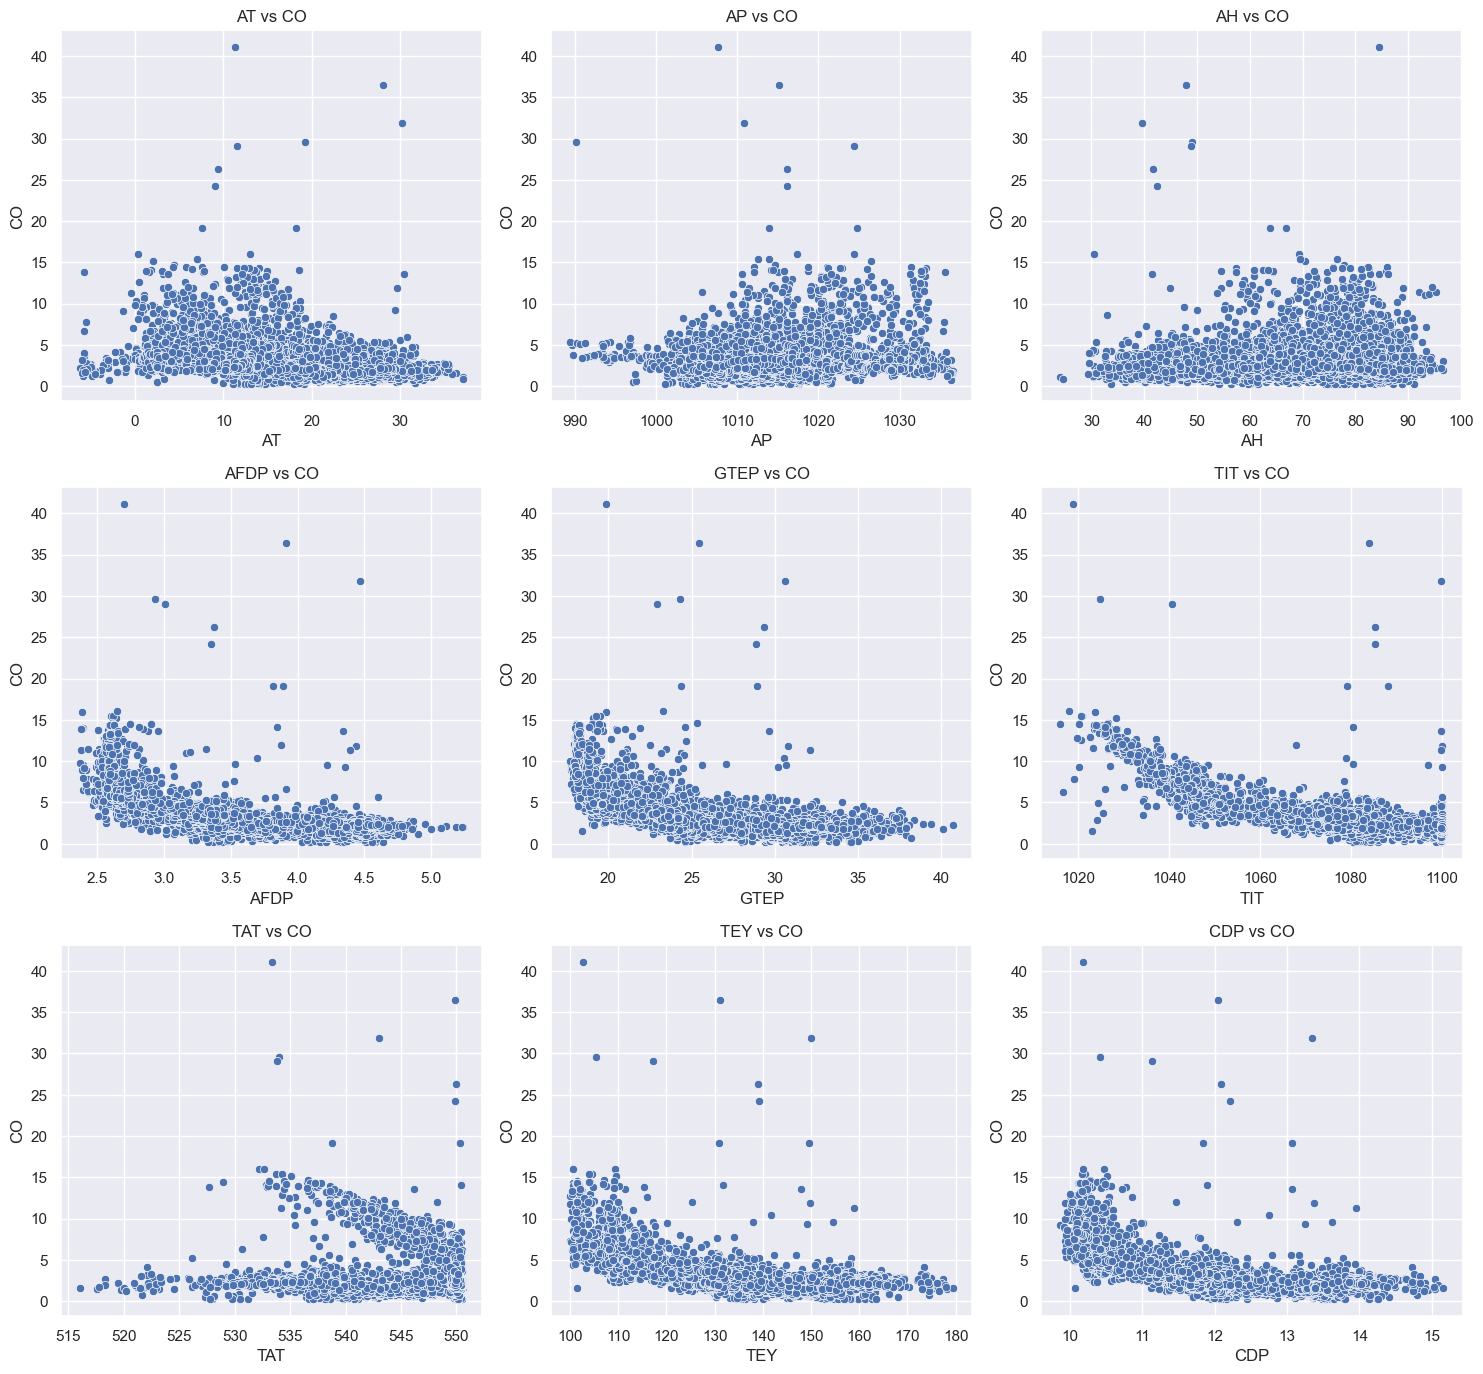

In [9]:
target = "CO"
plt.figure(figsize=(15, 18))
for i, col in enumerate(numeric_cols.drop(target), 1):
    plt.subplot(4, 3, i)
    sns.scatterplot(x=df[col], y=df[target])
    plt.title(f"{col} vs CO")
plt.tight_layout()
plt.show()

### EDA Summary

Key observations:
- No missing values or duplicate rows found.
- Identified features with skewed distributions.
- Outliers detected in CO, TIT, TAT and AP.
- Strong correlations noted between several features.
- CO shows nonlinear relationships with several features.

These insights guide the preprocessing decisions next.

## Data Preprocessing
This section prepares the dataset for machine learning models.

In [11]:
data = df.copy()
numeric_cols = data.select_dtypes(include=[np.number]).columns

### Outlier removal using IQR method

In [12]:
Q1 = data[numeric_cols].quantile(0.25)
Q3 = data[numeric_cols].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_clean = data[~((data[numeric_cols] < lower_bound) | (data[numeric_cols] > upper_bound)).any(axis=1)]

print("Original rows:", data.shape[0])
print("Cleaned rows:", df_clean.shape[0])

Original rows: 7384
Cleaned rows: 6227


### Train-test data split

In [22]:
from sklearn.model_selection import train_test_split

X = df_clean.drop("CO", axis=1)
y = df_clean["CO"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(X_train.shape)
print(X_test.shape)

(4981, 9)
(1246, 9)


### Scaling using StandardScaler

In [35]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# For displaying
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_train_scaled_df.describe()

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP
count,4.981000e+03,4.981000e+03,4.981000e+03,4.981000e+03,4.981000e+03,4.981000e+03,4.981000e+03,4.981000e+03,4.981000e+03
mean,4.693205e-16,-2.653302e-14,3.395085e-16,-5.381495e-16,3.673253e-16,3.538092e-15,1.708170e-14,-6.882892e-16,1.185427e-15
std,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00,1.000100e+00
min,-2.960528e+00,-2.889140e+00,-2.788422e+00,-2.164601e+00,-2.042949e+00,-2.628326e+00,-3.579547e+00,-2.461889e+00,-2.204559e+00
25%,-7.523346e-01,-7.642946e-01,-7.138562e-01,-7.779378e-01,-6.701769e-01,-4.273342e-01,-4.428380e-01,-3.530132e-01,-5.054179e-01
50%,4.811354e-02,-5.254098e-02,1.414280e-01,-1.185731e-01,-1.733443e-01,1.052887e-02,5.381772e-01,-1.324132e-01,-1.190596e-01
75%,7.825467e-01,6.244930e-01,8.150033e-01,1.006341e+00,9.746086e-01,1.137296e+00,6.080229e-01,9.434823e-01,1.044192e+00
max,2.316628e+00,3.089591e+00,2.088703e+00,2.307062e+00,3.176126e+00,1.178164e+00,7.762877e-01,2.191792e+00,1.837793e+00


### Summary
- Outliers removed using IQR method.
- Train-test split done with 80/20 ratio.
- StandardScaler applied to features (required for Linear Regression & Neural Networks).
- Final datasets prepared:
  - X_train_scaled, X_test_scaled
  - y_train, y_test